The data period is between May 2011 - Mar 2015.
The campaign date is on March 2015.
So, The simple data which will be applied to this model shouldn't be older than 2-3 years

> Case 1 : Use latest 2 years : March 2013 - March 2015 







## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
#Extract Year Month Year-Month
df_transactions['year'] = df_transactions['trans_date'].dt.strftime('%Y')
df_transactions['month'] = df_transactions['trans_date'].dt.strftime('%m')
df_transactions['year-month'] = df_transactions['trans_date'].dt.strftime('%Y-%m')

In [7]:
df_transactions.head()

,customer_id,trans_date,tran_amount,year,month,year-month
0,CS5295,2013-02-11,35,2013,02,2013-02
1,CS4768,2015-03-15,39,2015,03,2015-03
2,CS2122,2013-02-26,52,2013,02,2013-02
3,CS1217,2011-11-16,99,2011,11,2011-11
4,CS1850,2013-11-20,78,2013,11,2013-11


In [8]:
#Drop : 2011 - 2013-03 to get only 2 years remaining.
df_transactions = df_transactions[(df_transactions['year'] != '2011')]
df_transactions = df_transactions[(df_transactions['year'] != '2012')]
df_transactions = df_transactions[(df_transactions['year-month'] >= '2013-03')]

In [9]:
#Check : The Transactions are between 2013-03 and 2015-03
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2013-03-01 00:00:00
2015-03-16 00:00:00


In [10]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,year,month,year-month,recent
1,CS4768,2015-03-15,39,2015,03,2015-03,2.0
4,CS1850,2013-11-20,78,2013,11,2013-11,482.0
5,CS5539,2014-03-26,81,2014,03,2014-03,356.0
7,CS5902,2015-01-30,89,2015,01,2015-01,46.0
9,CS3802,2013-08-20,75,2013,08,2013-08,574.0


In [11]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [12]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,7,463
1,CS1113,36.0,12,872
2,CS1114,33.0,11,804
3,CS1115,12.0,11,831
4,CS1116,204.0,5,333


In [13]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [14]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,7,463,684,66.142857
1,CS1113,36.0,12,872,705,72.666667
2,CS1114,33.0,11,804,626,73.090909
3,CS1115,12.0,11,831,715,75.545455
4,CS1116,204.0,5,333,199,66.600000


## **Calculating response rate**

In [15]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


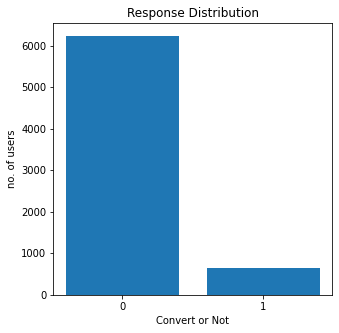

In [16]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [17]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,7,463
1,CS1113,0,36.0,12,872
2,CS1114,1,33.0,11,804
3,CS1115,1,12.0,11,831
4,CS1116,1,204.0,5,333


In [18]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,7,463,684,66.142857
1,CS1113,0,36.0,12,872,705,72.666667
2,CS1114,1,33.0,11,804,626,73.090909
3,CS1115,1,12.0,11,831,715,75.545455
4,CS1116,1,204.0,5,333,199,66.600000


## **Creating train and test dataset**

In [19]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [20]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

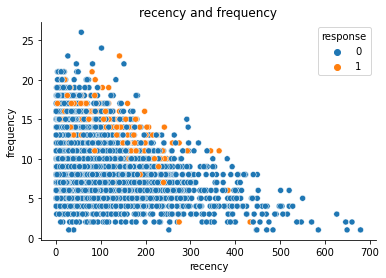

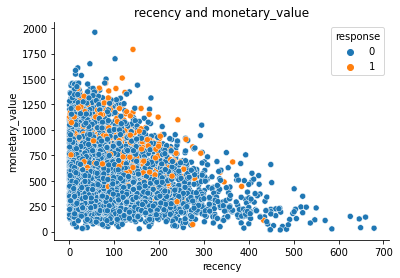

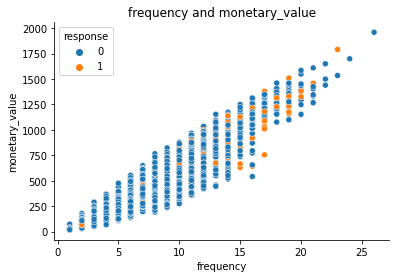

In [21]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

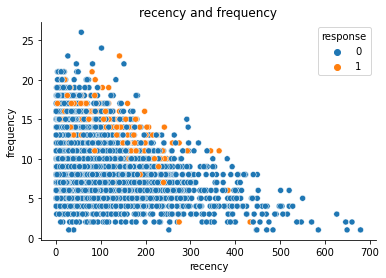

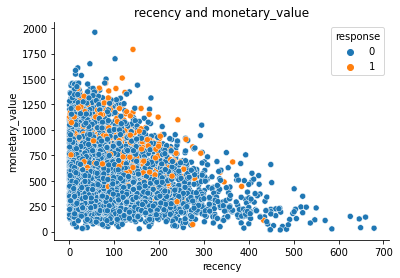

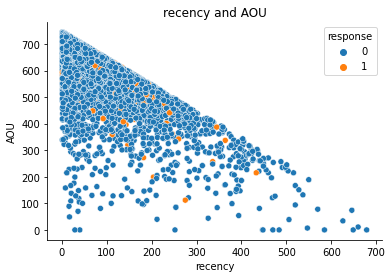

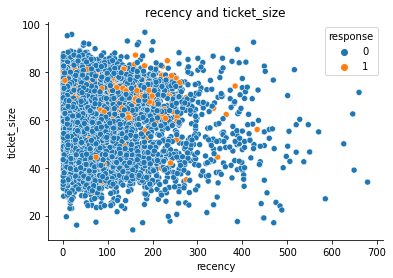

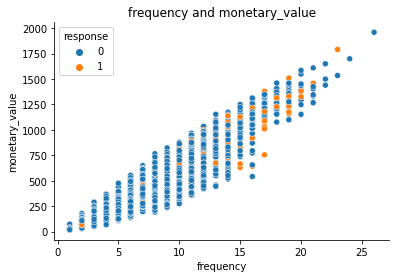

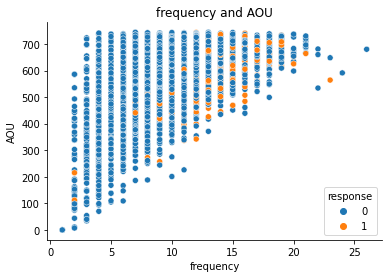

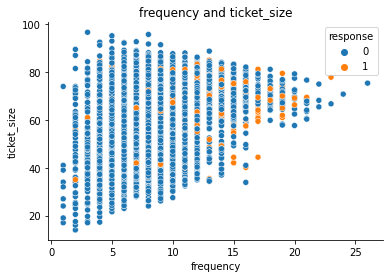

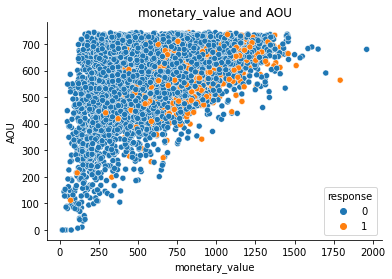

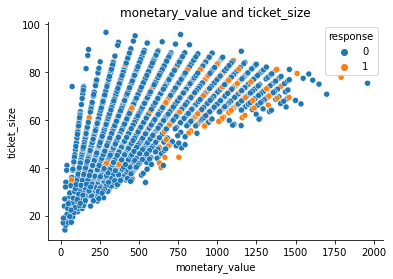

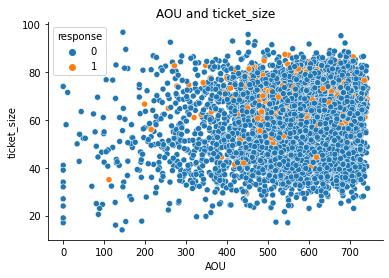

In [22]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [23]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


##**Fixing imbalanced with Undersampling**

In [24]:
runs = RandomUnderSampler(random_state=0)

runs.fit(X_train_rfm,y_train_rfm)
X_undersampled_rfm,y_undersampled_rfm = runs.fit_sample(X_train_rfm, y_train_rfm)
df_undersampled_rfm = pd.concat([pd.DataFrame(data=X_undersampled_rfm),pd.DataFrame(data=y_undersampled_rfm)],axis=1,sort=False)

runs.fit(X_train_clv,y_train_clv)
X_undersampled_clv,y_undersampled_clv = runs.fit_sample(X_train_clv, y_train_clv)
df_undersampled_clv = pd.concat([pd.DataFrame(data=X_undersampled_clv),pd.DataFrame(data=y_undersampled_clv)],axis=1,sort=False)

#df_undersampled.columns=['recency','frequency','monetary_value','response']

#sns.scatterplot(data=df_undersampled_rfm,x='recency', y='monetary_value', hue='response')
#sns.despine
#plt.title('Undersampledd Data')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


##**Fixing imbalanced with Oversampling**

In [25]:
runs = RandomOverSampler(random_state=0)

runs.fit(X_train_rfm,y_train_rfm)
X_oversampled_rfm,y_oversampled_rfm = runs.fit_sample(X_train_rfm, y_train_rfm)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled_rfm),pd.DataFrame(data=y_oversampled_rfm)],axis=1,sort=False)

runs.fit(X_train_clv,y_train_clv)
X_oversampled_clv,y_oversampled_clv = runs.fit_sample(X_train_clv, y_train_clv)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled_clv),pd.DataFrame(data=y_oversampled_clv)],axis=1,sort=False)

#df_oversampled.columns=['recency','frequency','monetary_value','response']

#sns.scatterplot(data=df_oversampled,x='recency', y='monetary_value', hue='response')
#sns.despine
#plt.title('Oversampledd Data')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

Logistic Regresstion - SMOTE RFM

In [26]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.72      0.69      0.71      4389
           1       0.70      0.72      0.71      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.77      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.69      0.75      2066



Logistic regression model - SMOTE RFM - AUC


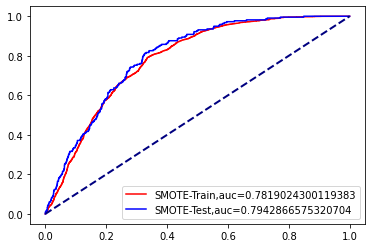

In [27]:
print('Logistic regression model - SMOTE RFM - AUC')
y_score_train = logreg_model_SMOTE_rfm.decision_function(X_SMOTE_rfm)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_rfm,y_score_train)
auc_train = roc_auc_score(y_SMOTE_rfm,y_score_train)
plt.plot(fpr_train,tpr_train,color='red',label='SMOTE-Train,auc='+str(auc_train))

y_score_test = logreg_model_SMOTE_rfm.decision_function(X_test_rfm)
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,y_score_test)
auc_test = roc_auc_score(y_test_rfm,y_score_test)
plt.plot(fpr_test,tpr_test,color='Blue',label='SMOTE-Test,auc='+str(auc_test))

plt.plot([0,1],[0,1],color='navy',lw=2,linestyle ='--')
plt.legend(loc=4)
plt.show()

Logistic Regresstion - SMOTE CLV

In [28]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4389
           1       0.71      0.75      0.73      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.78      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.69      0.75      2066



Logistic regression model - SMOTE clv - AUC


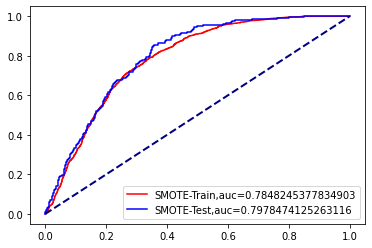

In [29]:
print('Logistic regression model - SMOTE clv - AUC')
y_score_train = logreg_model_SMOTE_clv.decision_function(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv,y_score_train)
auc_train = roc_auc_score(y_SMOTE_clv,y_score_train)
plt.plot(fpr_train,tpr_train,color='red',label='SMOTE-Train,auc='+str(auc_train))

y_score_test = logreg_model_SMOTE_clv.decision_function(X_test_clv)
fpr_test, tpr_test, _ = roc_curve(y_test_clv,y_score_test)
auc_test = roc_auc_score(y_test_clv,y_score_test)
plt.plot(fpr_test,tpr_test,color='Blue',label='SMOTE-Test,auc='+str(auc_test))

plt.plot([0,1],[0,1],color='navy',lw=2,linestyle ='--')
plt.legend(loc=4)
plt.show()

Logistic Regresstion - Undersampling RFM

In [30]:
print('logistic regression model - Undersampling RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_under_rfm = logreg.fit(X_undersampled_rfm, y_undersampled_rfm)
predictions = logreg_model_under_rfm.predict(X_undersampled_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - Undersampling RFM
training set
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       429
           1       0.70      0.76      0.73       429

    accuracy                           0.72       858
   macro avg       0.72      0.72      0.72       858
weighted avg       0.72      0.72      0.72       858

test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1848
           1       0.22      0.79      0.34       218

    accuracy                           0.68      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.89      0.68      0.74      2066



Logistic regression model - Undersampling RFM - AUC


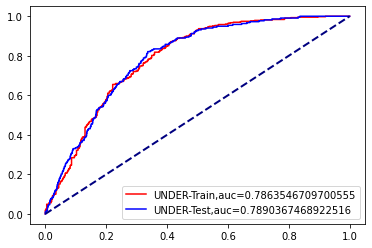

In [68]:
print('Logistic regression model - Undersampling RFM - AUC')
y_score_train = logreg_model_under_rfm.decision_function(X_undersampled_rfm)
fpr_train, tpr_train, _ = roc_curve(y_undersampled_rfm,y_score_train)
auc_train = roc_auc_score(y_undersampled_rfm,y_score_train)
plt.plot(fpr_train,tpr_train,color='red',label='UNDER-Train,auc='+str(auc_train))

y_score_test = logreg_model_under_rfm.decision_function(X_test_rfm)
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,y_score_test)
auc_test = roc_auc_score(y_test_rfm,y_score_test)
plt.plot(fpr_test,tpr_test,color='Blue',label='UNDER-Test,auc='+str(auc_test))

plt.plot([0,1],[0,1],color='navy',lw=2,linestyle ='--')
plt.legend(loc=4)
plt.show()

Logistic Regresstion - Undersampling CLV

In [32]:
print('logistic regression model - Undersampling CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_under_clv = logreg.fit(X_undersampled_clv, y_undersampled_clv)
predictions = logreg_model_under_clv.predict(X_undersampled_clv)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - Undersampling CLV
training set
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       429
           1       0.71      0.74      0.73       429

    accuracy                           0.72       858
   macro avg       0.72      0.72      0.72       858
weighted avg       0.72      0.72      0.72       858

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.22      0.76      0.34       218

    accuracy                           0.70      2066
   macro avg       0.59      0.72      0.57      2066
weighted avg       0.88      0.70      0.75      2066



Logistic regression model - Undersampling CLV - AUC


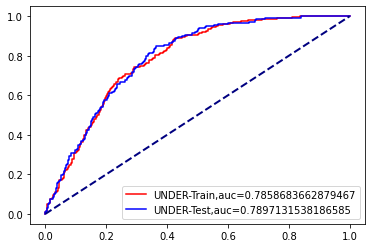

In [71]:
print('Logistic regression model - Undersampling CLV - AUC')
y_score_train = logreg_model_under_clv.decision_function(X_undersampled_clv)
fpr_train, tpr_train, _ = roc_curve(y_undersampled_clv,y_score_train)
auc_train = roc_auc_score(y_undersampled_clv,y_score_train)
plt.plot(fpr_train,tpr_train,color='red',label='UNDER-Train,auc='+str(auc_train))

y_score_test = logreg_model_under_clv.decision_function(X_test_clv)
fpr_test, tpr_test, _ = roc_curve(y_test_clv,y_score_test)
auc_test = roc_auc_score(y_test_clv,y_score_test)
plt.plot(fpr_test,tpr_test,color='Blue',label='UNDER-Test,auc='+str(auc_test))

plt.plot([0,1],[0,1],color='navy',lw=2,linestyle ='--')
plt.legend(loc=4)
plt.show()

Logistic Regression - Oversampling RFM

In [69]:
print('logistic regression model - Oversampling RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over_rfm = logreg.fit(X_oversampled_rfm, y_oversampled_rfm)
predictions = logreg_model_over_rfm.predict(X_oversampled_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - Oversampling RFM
training set
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      4389
           1       0.70      0.72      0.71      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.78      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.69      0.75      2066



Logistic regression model - Oversampling RFM - AUC


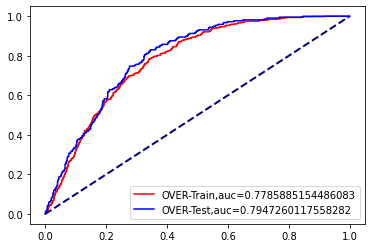

In [70]:
print('Logistic regression model - Oversampling RFM - AUC')
y_score_train = logreg_model_over_rfm.decision_function(X_oversampled_rfm)
fpr_train, tpr_train, _ = roc_curve(y_oversampled_rfm,y_score_train)
auc_train = roc_auc_score(y_oversampled_rfm,y_score_train)
plt.plot(fpr_train,tpr_train,color='red',label='OVER-Train,auc='+str(auc_train))

y_score_test = logreg_model_over_rfm.decision_function(X_test_rfm)
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,y_score_test)
auc_test = roc_auc_score(y_test_rfm,y_score_test)
plt.plot(fpr_test,tpr_test,color='Blue',label='OVER-Test,auc='+str(auc_test))

plt.plot([0,1],[0,1],color='navy',lw=2,linestyle ='--')
plt.legend(loc=4)
plt.show()

Logistic Regression - Oversampling CLV

In [36]:
print('logistic regression model - Oversampling CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over_clv = logreg.fit(X_oversampled_clv, y_oversampled_clv)
predictions = logreg_model_over_clv.predict(X_oversampled_clv)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - Oversampling CLV
training set
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4389
           1       0.70      0.74      0.72      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.78      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.69      0.75      2066



Logistic regression model - Oversampling CLV - AUC


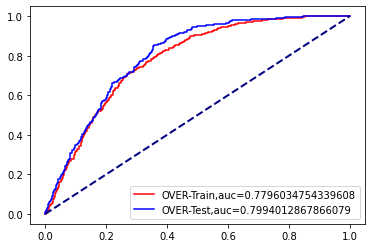

In [72]:
print('Logistic regression model - Oversampling CLV - AUC')
y_score_train = logreg_model_over_clv.decision_function(X_oversampled_clv)
fpr_train, tpr_train, _ = roc_curve(y_oversampled_clv,y_score_train)
auc_train = roc_auc_score(y_oversampled_clv,y_score_train)
plt.plot(fpr_train,tpr_train,color='red',label='OVER-Train,auc='+str(auc_train))

y_score_test = logreg_model_over_clv.decision_function(X_test_clv)
fpr_test, tpr_test, _ = roc_curve(y_test_clv,y_score_test)
auc_test = roc_auc_score(y_test_clv,y_score_test)
plt.plot(fpr_test,tpr_test,color='Blue',label='OVER-Test,auc='+str(auc_test))

plt.plot([0,1],[0,1],color='navy',lw=2,linestyle ='--')
plt.legend(loc=4)
plt.show()

## **XGBoost**

XGBoost model - SMOTE RFM

In [38]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.567615
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.770693
[2]	validation_0-auc:0.757932
[3]	validation_0-auc:0.755425
[4]	validation_0-auc:0.760407
[5]	validation_0-auc:0.770693
[6]	validation_0-auc:0.764939
Stopping. Best iteration:
[1]	validation_0-auc:0.770693

training set
              precision    recall  f1-score   support

           0       0.81      0.61      0.70      4389
           1       0.69      0.86      0.76      4389

    accuracy                           0.73      8778
   macro avg       0.75      0.73      0.73      8778
weighted avg       0.75      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      1848
           1       0.20      0.82      0.32       218

    accuracy                           0.63      2066
   macro avg       0.58      0.71      0.53      2066
weighted avg       0.88

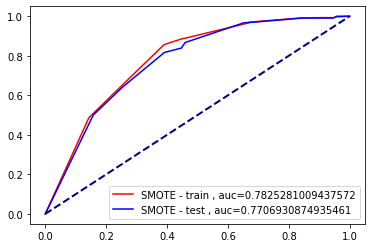

In [53]:
y_score_train = xgb_model_SMOTE_rfm.predict_proba(X_SMOTE_rfm)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_rfm,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_rfm, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE_rfm.predict_proba(X_test_rfm.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,  y_score_test[:,1])
auc_test = roc_auc_score(y_test_rfm, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

XGBoost model - SMOTE CLV

In [39]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.754025
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.780978
[2]	validation_0-auc:0.780978
[3]	validation_0-auc:0.782713
[4]	validation_0-auc:0.782296
[5]	validation_0-auc:0.782788
[6]	validation_0-auc:0.783763
[7]	validation_0-auc:0.786475
[8]	validation_0-auc:0.783174
[9]	validation_0-auc:0.784819
[10]	validation_0-auc:0.785621
[11]	validation_0-auc:0.78549
[12]	validation_0-auc:0.784355
Stopping. Best iteration:
[7]	validation_0-auc:0.786475

training set
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      4389
           1       0.69      0.89      0.77      4389

    accuracy                           0.74      8778
   macro avg       0.76      0.74      0.74      8778
weighted avg       0.76      0.74      0.74      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.59      0.73      1848
    

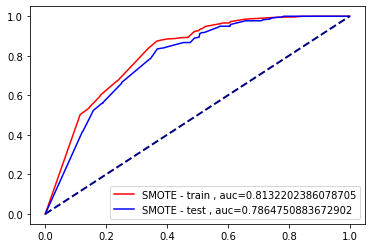

In [54]:
y_score_train = xgb_model_SMOTE_clv.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv,  y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

XGBoost model - Undersampling RFM

In [56]:
print('XGBoost model - Undersampled RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_under_rfm = xgb_model.fit(X_undersampled_rfm, y_undersampled_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_under_rfm.predict(X_undersampled_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - Undersampled RFM
[0]	validation_0-auc:0.559626
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.766594
[2]	validation_0-auc:0.766601
[3]	validation_0-auc:0.756218
[4]	validation_0-auc:0.761597
[5]	validation_0-auc:0.759986
[6]	validation_0-auc:0.771899
[7]	validation_0-auc:0.777517
[8]	validation_0-auc:0.779136
[9]	validation_0-auc:0.777684
[10]	validation_0-auc:0.777434
[11]	validation_0-auc:0.777339
[12]	validation_0-auc:0.788422
[13]	validation_0-auc:0.789117
[14]	validation_0-auc:0.788969
[15]	validation_0-auc:0.790428
[16]	validation_0-auc:0.788566
[17]	validation_0-auc:0.789731
[18]	validation_0-auc:0.787295
[19]	validation_0-auc:0.787107
[20]	validation_0-auc:0.787283
Stopping. Best iteration:
[15]	validation_0-auc:0.790428

training set
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       429
           1       0.70      0.81      0.75       429

    accuracy                

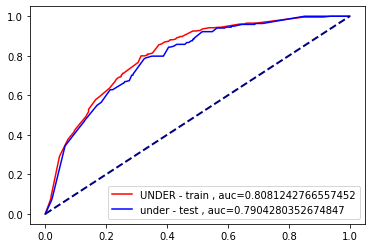

In [57]:
y_score_train = xgb_model_under_rfm.predict_proba(X_undersampled_rfm)
fpr_train, tpr_train, _ = roc_curve(y_undersampled_rfm,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled_rfm, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='UNDER - train , auc='+str(auc_train))

y_score_test = xgb_model_under_rfm.predict_proba(X_test_rfm.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,  y_score_test[:,1])
auc_test = roc_auc_score(y_test_rfm, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='UNDER - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

XGBoost model - Undersampling CLV

In [60]:
print('XGBoost model - Undersampled CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_under_clv = xgb_model.fit(X_undersampled_clv, y_undersampled_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_under_clv.predict(X_undersampled_clv)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - Undersampled CLV
[0]	validation_0-auc:0.751752
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.752927
[2]	validation_0-auc:0.752927
[3]	validation_0-auc:0.765909
[4]	validation_0-auc:0.766025
[5]	validation_0-auc:0.767399
[6]	validation_0-auc:0.767935
[7]	validation_0-auc:0.760633
[8]	validation_0-auc:0.757153
[9]	validation_0-auc:0.756713
[10]	validation_0-auc:0.75754
[11]	validation_0-auc:0.757895
Stopping. Best iteration:
[6]	validation_0-auc:0.767935

training set
              precision    recall  f1-score   support

           0       0.81      0.61      0.70       429
           1       0.69      0.86      0.76       429

    accuracy                           0.73       858
   macro avg       0.75      0.73      0.73       858
weighted avg       0.75      0.73      0.73       858

test set
              precision    recall  f1-score   support

           0       0.97      0.58      0.73      1848
           1       0.19     

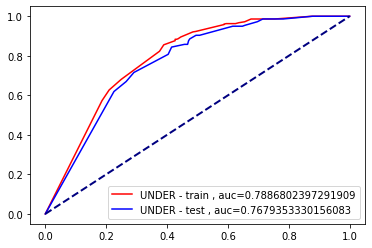

In [61]:
y_score_train = xgb_model_under_clv.predict_proba(X_undersampled_clv)
fpr_train, tpr_train, _ = roc_curve(y_undersampled_clv,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled_clv, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='UNDER - train , auc='+str(auc_train))

y_score_test = xgb_model_under_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv,  y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='UNDER - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

XGBoost model -Oversampling RFM

In [58]:
print('XGBoost model - Oversampled RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_over_rfm = xgb_model.fit(X_oversampled_rfm, y_oversampled_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_over_rfm.predict(X_oversampled_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - Oversampled RFM
[0]	validation_0-auc:0.566571
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.763631
[2]	validation_0-auc:0.761757
[3]	validation_0-auc:0.740666
[4]	validation_0-auc:0.765408
[5]	validation_0-auc:0.763631
[6]	validation_0-auc:0.76556
[7]	validation_0-auc:0.776883
[8]	validation_0-auc:0.776255
[9]	validation_0-auc:0.776237
[10]	validation_0-auc:0.774748
[11]	validation_0-auc:0.774706
[12]	validation_0-auc:0.774723
Stopping. Best iteration:
[7]	validation_0-auc:0.776883

training set
              precision    recall  f1-score   support

           0       0.79      0.60      0.69      4389
           1       0.68      0.84      0.75      4389

    accuracy                           0.72      8778
   macro avg       0.74      0.72      0.72      8778
weighted avg       0.74      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.60      0.74      184

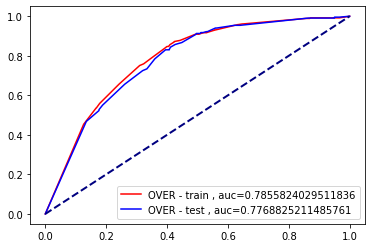

In [59]:
y_score_train = xgb_model_over_rfm.predict_proba(X_oversampled_rfm)
fpr_train, tpr_train, _ = roc_curve(y_oversampled_rfm,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled_rfm, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='OVER - train , auc='+str(auc_train))

y_score_test = xgb_model_over_rfm.predict_proba(X_test_rfm.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,  y_score_test[:,1])
auc_test = roc_auc_score(y_test_rfm, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='OVER - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [ ]:
XGBoost model -Oversampling CLV

In [62]:
print('XGBoost model - Oversampled CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_over_clv = xgb_model.fit(X_oversampled_clv, y_oversampled_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_over_clv.predict(X_oversampled_clv)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - Oversampled CLV
[0]	validation_0-auc:0.725638
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.756696
[2]	validation_0-auc:0.769796
[3]	validation_0-auc:0.785141
[4]	validation_0-auc:0.785603
[5]	validation_0-auc:0.786955
[6]	validation_0-auc:0.787432
[7]	validation_0-auc:0.787281
[8]	validation_0-auc:0.788236
[9]	validation_0-auc:0.785814
[10]	validation_0-auc:0.787186
[11]	validation_0-auc:0.786764
[12]	validation_0-auc:0.789676
[13]	validation_0-auc:0.788946
[14]	validation_0-auc:0.790267
[15]	validation_0-auc:0.786444
[16]	validation_0-auc:0.78914
[17]	validation_0-auc:0.784724
[18]	validation_0-auc:0.784101
[19]	validation_0-auc:0.782934
Stopping. Best iteration:
[14]	validation_0-auc:0.790267

training set
              precision    recall  f1-score   support

           0       0.81      0.56      0.66      4389
           1       0.66      0.87      0.75      4389

    accuracy                           0.71      8778
   macr

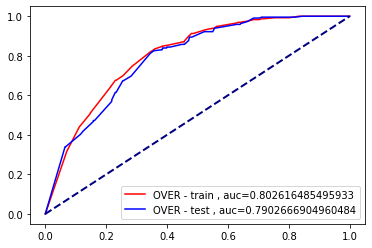

In [63]:
y_score_train = xgb_model_over_clv.predict_proba(X_oversampled_clv)
fpr_train, tpr_train, _ = roc_curve(y_oversampled_clv,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled_clv, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='OVER - train , auc='+str(auc_train))

y_score_test = xgb_model_over_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv,  y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='OVER - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [75]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [76]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score), 'F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_rfm_GS = grid.fit(X_train_rfm, y_train_rfm)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.5min finished


In [77]:
predicted_y = []
expected_y = []
predictions = xgb_model_rfm_GS.predict(X_test_rfm)
print('Best AUC Score: {}'.format(xgb_model_rfm_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_rfm, predictions)))
print(confusion_matrix(y_test_rfm,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7626080744558595
Accuracy: 0.6892545982575025
[[1265  583]
 [  59  159]]
test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.21      0.73      0.33       218

    accuracy                           0.69      2066
   macro avg       0.58      0.71      0.56      2066
weighted avg       0.88      0.69      0.75      2066



In [78]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score), 'F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.5min finished


In [79]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_clv, predictions)))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7626080744558595
Accuracy: 0.6892545982575025
[[1265  583]
 [  59  159]]
test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.21      0.73      0.33       218

    accuracy                           0.69      2066
   macro avg       0.58      0.71      0.56      2066
weighted avg       0.88      0.69      0.75      2066

